In [1]:
import numpy as np
import pandas as pd
import os

DATA_ROOT = "../input/"
training_data= pd.read_csv(os.path.join(DATA_ROOT,'train_offline.csv'))
testing_data = pd.read_csv(os.path.join(DATA_ROOT,'test_offline.csv'))
testing_data = testing_data[~testing_data.Coupon_id.isna()]
testing_data.reset_index(drop=True, inplace=True)
print(training_data.shape)
print(testing_data.shape)
training_data.head()

(1160742, 7)
(306313, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN


In [2]:
## generate ground-truth data
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

training_data["label"] = training_data.apply(label, axis=1)
training_data["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

In [3]:
# Generate features - weekday acquired coupon
def getWeekday(row):
    if (np.isnan(row)) or (row==-1):
        return row
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7
    
training_data['weekday'] = training_data['Date_received'].apply(getWeekday)
testing_data['weekday'] = testing_data['Date_received'].apply(getWeekday)

# weekday_type (weekend = 1)
training_data['weekday_type'] = training_data['weekday'].astype('float').apply(lambda x : 1 if x > 5 else 0 ) # apply to trainset
testing_data['weekday_type'] = testing_data['weekday'].astype('float').apply(lambda x : 1 if x > 5 else 0 ) # apply to testset

In [4]:
# Generate features - coupon discount and distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 1

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)
# def convertRate(row):
#     """Convert discount to rate"""
#     if row == 'NAN':
#         return 0
#     elif ':' in row:
#         rows = row.split(':')
#         return float(rows[1])/float(rows[0])
#     else:
#         return 1-float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    # convert distance
    df.loc[df.Distance.isna(), "Distance"] = 100
    return df

training_data = processData(training_data)
testing_data = processData(testing_data)

In [5]:
training_data.loc[training_data.discount_rate.isna(), "discount_rate"] = 1
training_data.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_type,discount_rate,discount_man,discount_jian,discount_type
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,NaN,0,1.00,0,0,1
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0,0.95,20,1,1
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,1,0.95,20,1,1
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5.0,0,0.90,200,20,1
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5.0,0,0.90,200,20,1


In [6]:
training_data.discount_jian.value_counts()

0      441232
5      278240
10     199749
20     117648
30      86224
1       32412
50       5228
100         9
Name: discount_jian, dtype: int64

In [7]:
testing_data.Distance.value_counts()

0.0      135755
1.0       48858
100.0     36177
10.0      22765
2.0       20236
3.0       12870
4.0        9003
5.0        6376
6.0        4905
7.0        3755
8.0        3007
9.0        2606
Name: Distance, dtype: int64

In [8]:
# generate training set and validation set:

def split_train_valid(row, date_cut="20160416"):
    is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
    return is_train
    
# training_set = training_data[(training_data['label'] != -1) & (training_data['Distance'] != 100)].copy()
training_set = training_data[(training_data['label'] != -1) & (training_data['Distance'] != 100)]
training_set["is_train"] = training_set["Date_received"].apply(split_train_valid)
training = training_set[training_set["is_train"]]
validation = training_set[~training_set["is_train"]]
training.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)
print("Train size: {}, #positive: {}".format(len(training), training["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(validation), validation["label"].sum()))

Train size: 605834, #positive: 29102
Valid size: 71309, #positive: 3412


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
training.head()
discount_rate = np.asarray(training['discount_rate'])
discount_man = np.asarray(training['discount_man']) # normalize to 0 ~ 1
discount_jian = np.asarray(training['discount_jian'])   # normalize to 0 ~ 1
discount_type = np.asarray(training['discount_type']) 
weekday_type = np.asarray(training['weekday_type'])
distance = np.asarray(training['Distance'])      # normalize to 0 ~ 10

x_train = np.dstack((discount_type, discount_rate, discount_man, discount_jian, weekday_type,distance))
x_train = np.squeeze(x_train)
y_train = np.asarray(training['label'])
print(y_train.shape)
print(x_train.shape)

(605834,)
(605834, 6)


In [10]:
validation.head()
discount_rate_validation = np.asarray(validation['discount_rate'])
discount_man_validation = np.asarray(validation['discount_man'])
discount_jian_validation = np.asarray(validation['discount_jian'])
discount_type_validation = np.asarray(validation['discount_type'])
weekday_type_validation = np.asarray(validation['weekday_type'])
distance_validation = np.asarray(validation['Distance'])

x_val = np.dstack((discount_type_validation ,discount_rate_validation, discount_man_validation,discount_jian_validation, weekday_type_validation,distance_validation))
x_val = np.squeeze(x_val)
y_val = np.asarray(validation['label'])
print(y_val.shape)
print(x_val.shape)

(71309,)
(71309, 6)


In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from keras.utils.np_utils import to_categorical

class Coupon(nn.Module):
    def __init__(self):
        super(Coupon, self).__init__()
        
        #fully-connected neural network
        #layer1
        self.layer1=nn.Sequential(
        nn.Linear(in_features=6, out_features=16, bias =True),
        nn.LeakyReLU())
        
        #layer2
        self.layer2=nn.Sequential(
        nn.Linear(in_features=16, out_features=16, bias =True),
        nn.LeakyReLU())
        
        #layer3
        self.layer3=nn.Sequential(
        nn.Linear(in_features=16, out_features=16, bias =True),
        nn.LeakyReLU())
        
        #layer4
        self.layer4=nn.Sequential(
        nn.Linear(in_features=16, out_features=2, bias =True),
        nn.Sigmoid())
        
    def forward(self, x):
        x = torch.cuda.FloatTensor(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        return out

Using TensorFlow backend.


In [12]:
model=Coupon()
model.cuda()

x_train = torch.cuda.FloatTensor(x_train)
y_train = torch.cuda.FloatTensor(y_train)

y_label = to_categorical(y_train.detach().cpu())
y_label = torch.cuda.FloatTensor(y_label)


x_val = torch.cuda.FloatTensor(x_val)
y_val = torch.cuda.FloatTensor(y_val)
y_val_label = to_categorical(y_val.detach().cpu())
y_val_label = torch.cuda.FloatTensor(y_val_label)

In [13]:
epoch = 50
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=5e-5)
batch_size=8192
acc_train=[]
acc_test=[]


for epoch in range(epoch):
    
    index = np.arange(0,605833,1)
    np.random.shuffle(index)
    
    for i in range(80):
        #training 
        model.train()
        inputs = x_train[index[i*batch_size : i*batch_size+batch_size]]
        label = y_label[index[i*batch_size : i*batch_size+batch_size]]
        Label = y_train[index[i*batch_size : i*batch_size+batch_size]]

        inputs = Variable(inputs)
        label = Variable(label)
        
        #optimization and update parameters
        optimizer.zero_grad()
        y_pred = model.forward(inputs)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        #all training data
        inputs = x_train
        label = y_label
        Label = y_train
        y_pred = model.forward(inputs)
    
    
        #all esting data
        inputs_test = x_val
        label_test = y_val_label
        Label_test = y_val
        y_pred_test = model.forward(inputs_test)
    
        correct_train=0
        wrong_train=0
        correct_test=0
        wrong_test=0
    
        _, predicted1 = torch.max(y_pred.data, 1)
        _, predicted2 = torch.max(y_pred_test.data, 1)

        for n in range(605834):
            if (predicted1[n] == int(Label[n])):
                correct_train +=1
            else:
                wrong_train +=1
    
        for q in range(71309):
            if (predicted2[q]==int(Label_test[q])):
                correct_test +=1
            else:
                wrong_test +=1
    
    acc1 = round(correct_train/ (correct_train + wrong_train) *100,3)
    acc2 = round(correct_test/ (correct_test + wrong_test) *100,3)
    acc_train.append(acc1)
    acc_test.append(acc2)

    print(epoch, round(loss.item(),4), acc1, acc2)


0 nan 95.196 95.215
1 nan 95.196 95.215
2 nan 95.196 95.215
3 nan 95.196 95.215
4 nan 95.196 95.215
5 nan 95.196 95.215
6 nan 95.196 95.215
7 nan 95.196 95.215
8 nan 95.196 95.215
9 nan 95.196 95.215
10 nan 95.196 95.215
11 nan 95.196 95.215
12 nan 95.196 95.215
13 nan 95.196 95.215
14 nan 95.196 95.215
15 nan 95.196 95.215
16 nan 95.196 95.215
17 nan 95.196 95.215
18 nan 95.196 95.215
19 nan 95.196 95.215
20 nan 95.196 95.215
21 nan 95.196 95.215
22 nan 95.196 95.215
23 nan 95.196 95.215
24 nan 95.196 95.215
25 nan 95.196 95.215
26 nan 95.196 95.215
27 nan 95.196 95.215
28 nan 95.196 95.215
29 nan 95.196 95.215
30 nan 95.196 95.215
31 nan 95.196 95.215
32 nan 95.196 95.215
33 nan 95.196 95.215
34 nan 95.196 95.215
35 nan 95.196 95.215
36 nan 95.196 95.215
37 nan 95.196 95.215
38 nan 95.196 95.215
39 nan 95.196 95.215
40 nan 95.196 95.215
41 nan 95.196 95.215
42 nan 95.196 95.215
43 nan 95.196 95.215
44 nan 95.196 95.215
45 nan 95.196 95.215
46 nan 95.196 95.215
47 nan 95.196 95.215
48

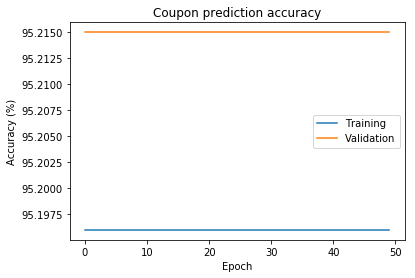

In [14]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
epoch = np.arange(0,50,1)
Train =plt.plot(epoch, acc_train, linestyle='solid',label="Training")
Val =plt.plot(epoch, acc_test, linestyle='solid',label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Coupon prediction accuracy",fontsize=12)
plt.legend()
plt.savefig('./test.png')

np.save("./training.npy", acc_train)
np.save("./validation.npy", acc_test)

plt.show()

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score

y_val_label =y_val_label.detach().cpu()
y_val_label = np.asarray(y_val_label)
# print(y_val_label.shape)

y_pred_test = y_pred_test.detach().cpu()
y_pred_test = np.asarray(y_pred_test)
# print(y_pred_test.shape)

predicted2 = predicted2.detach().cpu()
predicted2 = np.asarray(predicted2)

auc_score = roc_auc_score(y_true=y_val_label[:,1], y_score=y_pred_test[:,1])
acc = accuracy_score(y_true=y_val_label[:,1], y_pred=predicted2)

print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.786, Accuracy: 0.952


In [16]:
discount_rate_test = np.asarray(testing_data['discount_rate'])
discount_man_test = np.asarray(testing_data['discount_man']) # normalize to 0 ~ 1
discount_jian_test = np.asarray(testing_data['discount_jian'])   # normalize to 0 ~ 1
discount_type_test = np.asarray(testing_data['discount_type']) 
weekday_type_test = np.asarray(testing_data['weekday_type'])
distance_test = np.asarray(testing_data['Distance'])        # normalize to 0 ~ 10

x_test = np.dstack((discount_type_test, discount_rate_test, discount_man_test, discount_jian_test, weekday_type_test,distance_test))
x_test = np.squeeze(x_test)

print(x_test.shape)


targetset = testing_data.copy()
print(targetset.shape)
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)


y_test_pred = model.forward(x_test)
test1 = targetset.copy()
print(y_test_pred.shape)
print(test1.shape)
y_test_pred = y_test_pred.detach().cpu().numpy()
print(y_test_pred)
test1['pred_prob'] = y_test_pred[:,1]
print(test1.shape)

(306313, 6)
(306313, 12)
torch.Size([306313, 2])
(306313, 12)
[[0.9734759  0.02782484]
 [0.8707332  0.13039342]
 [0.8707332  0.13039342]
 ...
 [0.9806337  0.01843761]
 [0.9949628  0.00483484]
 [0.76621515 0.23510157]]
(306313, 13)


In [17]:
test1['pred_prob'].max()

0.28320026

In [18]:
output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test1["pred_prob"]), axis=1)
print(output.shape)

output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)

(306313, 4)


In [19]:
### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
out.to_csv("prediction.csv", header=["uid", "label"], index=False) # submission format
out.head(30)

,uid,label
0,1000020_2705_20160519,2.351016e-01
1,1000020_8192_20160513,2.351016e-01
2,1000065_1455_20160527,9.094165e-02
3,1000085_8067_20160513,1.481888e-01
4,1000086_2418_20160613,1.481888e-01
5,1000140_8192_20160526,2.351016e-01
6,1000169_2418_20160606,1.481888e-01
7,1000297_13704_20160520,3.867410e-02
8,1000324_13165_20160526,5.638128e-02
9,1000338_10161_20160612,2.828085e-04
